<div style="border: 1px solid #CCCCFF; border-radius: 1px;">
<div style="margin: 5px">
<b class="alert-heading">Комментарий ревьюера</b>
<p>Алексей, привет!</p>
<p>Меня зовут Алексей Секоцкий. Поздравляю с подготовкой очередного проекта. Предлагаю обращаться друг к другу на «ты» если нет возражений. Ниже стандартный блок с условными обозначениями:</p>
<div class="alert alert-success" role="alert">
всё отлично
</div>
<div class="alert alert-warning" role="alert">
рекомендации на будущее (не требующие доработки проекта)
</div>
<div class="alert alert-danger" role="alert">
критичные моменты требующие внимания (доработки)
</div>
<div class="alert alert-info">
итоговый комментарий
</div>

<hr>
<p>Пожалуйста, не изменяй и не удаляй мои комментарии – они потребуются для повторной проверки (при необходимости). Задавай вопросы и описывай сделанные изменения, помечая их любым удобным наглядным способом.</p>

# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def analyze_df(df):
    rows_count, columns_count = df.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    display(df.head(5))
    display(df.describe())
    df.info()

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 
analyze_df(labels)

Found 7591 validated image filenames.
Количество стобцов: 2
Количество строк: 7591


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Размер выборки - 7591 объектов

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Отлично. Данные загружены.
</div>

Выведем график распределения возраста в выборке

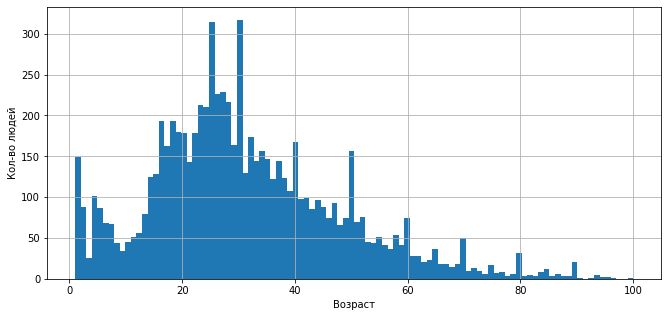

In [4]:
labels['real_age'].hist(
    bins=100,
    grid=True, 
    figsize=(11, 5),
).set(xlabel='Возраст', ylabel='Кол-во людей')
plt.show()

Больше всего людей - от 23 до 30 лет, медианное значение возраста - 29 лет, среднее - 31 год

<div class="alert alert-warning">
<b>Комментарий ревьюера</b>

Здесь уместнее гистограмма со 100 корзинами. Важно обратить внимание на пики на круглые даты начиная с 20 и предположить откуда они появились.
</div>

<div class="alert alert-info">
Видны пики каждые 10 лет, начиная с 20 лет. Скорее всего это связано с округлением возраста
</div>

Выведем 15 фотографий и посмотрим, как устроен датасет

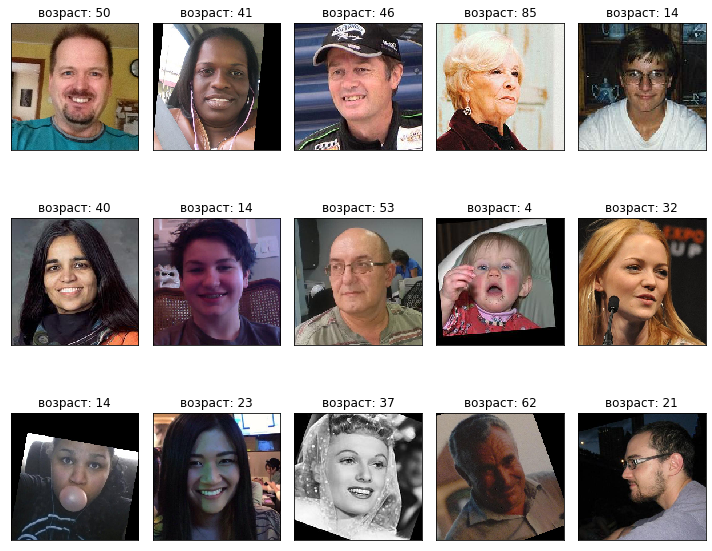

In [5]:
rows, cols = 3, 5
fig = plt.figure(figsize=(10,10))
features, target = next(train_gen_flow)

for idx in range(15):
    fig.add_subplot(rows, cols, idx + 1)
    plt.imshow(features[idx])
    plt.title('возраст: ' + str(target[idx]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

На фотографиях изображены люди и возраст указан верно 

**Выводы**:
* Выборка содержит 7591 изображение, для увеличения кол-ва данных можно использовать аугментацию, например отражение по горизонтали
* Людей от 20 до 30 лет в выборке больше всего, их-за этого модель сможет обучиться и угадывать их лучше
* Есть пики каждые 10 лет, это скорее всего связвно с тем, что у некоторых людей возраст округляется
* Возраст на фотографиях указан верно
* Среди фотографий есть как цветные, так и черно-белые. Также фотографии имеют разное качество.
* Можно заметить, что некоторые фотографии повернуты, но скорее всего это не будет мешать обучению, поскольку необходимые признаки остаются на месте.

<div class="alert alert-danger">
<b>Комментарий от ревьюера</b>

По результатам анализа датасета, гистограммы и фото необходимы следующие уточнения:

1. Выводы по гистограмме. Обратить внимание на пики (каждые 10 лет начиная с 20 лет), выбросы и т.п. и выдвинуть предположения почему они могли появиться.
3. По фото. Описать особенности увиденные на фото: цветность, качество, размер лиц, угол поворота и т.п. и предложить аугментацию (тем более, что аугментация уже используется в коде ниже).
<br/>
</div>

<div class="alert alert-info">
Добавил
</div>    

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Супер!
</div>

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
 
optimizer = Adam(lr=0.0001)
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        directory=path + 'final_files/',
        dataframe=labels,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        directory=path + 'final_files/',
        dataframe=labels,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return train_datagen_flow
 
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)    
    
    model = Sequential()
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              validation_data=test_data,
              steps_per_epoch=steps_per_epoch,
              epochs=epochs,
              batch_size=batch_size,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```
Train for 356 steps, validate for 119 steps
Epoch 1/10
2021-04-12 20:56:33.283362: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-04-12 20:56:33.625428: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 51s - loss: 206.1737 - mae: 10.4487 - val_loss: 650.5715 - val_mae: 20.5352
Epoch 2/10
356/356 - 41s - loss: 84.0253 - mae: 6.9701 - val_loss: 136.1557 - val_mae: 8.9506
Epoch 3/10
356/356 - 42s - loss: 56.5340 - mae: 5.7066 - val_loss: 88.5709 - val_mae: 7.2070
Epoch 4/10
356/356 - 41s - loss: 46.9425 - mae: 5.2251 - val_loss: 86.7613 - val_mae: 7.1027
Epoch 5/10
356/356 - 41s - loss: 32.5379 - mae: 4.3795 - val_loss: 79.2518 - val_mae: 6.8440
Epoch 6/10
356/356 - 40s - loss: 25.3793 - mae: 3.8612 - val_loss: 76.7729 - val_mae: 6.7708
Epoch 7/10
356/356 - 41s - loss: 20.6822 - mae: 3.4837 - val_loss: 74.1095 - val_mae: 6.4888
Epoch 8/10
356/356 - 42s - loss: 17.0385 - mae: 3.1707 - val_loss: 80.8831 - val_mae: 6.7049
Epoch 9/10
356/356 - 42s - loss: 15.2980 - mae: 2.9639 - val_loss: 67.6973 - val_mae: 6.0009
Epoch 10/10
356/356 - 43s - loss: 13.1834 - mae: 2.7626 - val_loss: 70.7575 - val_mae: 6.2442
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 70.7575 - mae: 6.2442
Test MAE: 6.2442

```

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Хорошая метрика!
</div>

## Анализ обученной модели

Модель построена на основе ResNet50, и в качестве метрики использовалась MAE.
Модель показала на тестовой выборке неплохой результат - 6.2, это значит, что она сможет определять возраст покупатлей с ошибкой примерно в 6 лет и ее можно внедрять в магазины.

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Верный вывод. Можно добавить пару слов про переобучение модели.    
</div>

<div class="alert alert-info">
<b>Итоговый комментарий ревьюера</b>

Отличный проект. Можно было принять с 1 раза, однако, настоятельно рекомендую доработать 1 раздел. Буду ждать новую версию.
<hr>
</div>

<div class="alert alert-info">
<b>Итоговый комментарий ревьюера</b>

Получился проект с отличной визуализацией и выводами! Поздравляю с завершением очередного спринта! Желаю успехов в дальнейшем обучении!
<hr>
</div>

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы